# Compare Models

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [4]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast'
# TARGET_VAR =      'VCI3M'
TARGET_VAR =      'boku_VCI'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'features/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


In [5]:
# # EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
# EXPERIMENT =      '000_one_month_forecast_BASE_static_vars'
# # TRUE_EXPERIMENT = 'one_month_forecast'
# TRUE_EXPERIMENT = '000_one_month_forecast_BASE_static_vars'
# TARGET_VAR =      'boku_VCI'

# assert (data_dir / f'models/{EXPERIMENT}').exists()
# assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

# print((data_dir / f'models/{EXPERIMENT}').as_posix())

# Read in the data

In [6]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [7]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
Data variables:
    boku_VCI    (time, lat, lon) float64 82.14 83.13 71.48 ... 29.12 77.78 49.71
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 4.625 4.678 4.806 4.71 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat       (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 74.48 83.21 84.39 ... 29.12 77.78 49.71

In [8]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

# bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
# lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

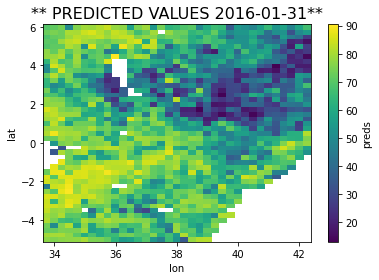

In [9]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

### Load in the models

In [10]:
from src.models import load_model

ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
ealstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

10

In [11]:
dynamic_ds = ds.drop([v for v in ealstm.ignore_vars if v in list(ds.data_vars)])

static_vars_to_include = [
    v
    for v in static_ds.data_vars
    if all([ign_v not in v for ign_v in ealstm.ignore_vars])
]
static = static_ds[static_vars_to_include]

In [12]:
static

<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lon                                         (lon) float32 33.75 ... 42.25
  * lat                                         (lat) float32 -5.0 -4.75 ... 6.0
Data variables:
    precip_global_mean                          (lat, lon) float64 ...
    E_global_mean                               (lat, lon) float64 ...
    SMsurf_global_mean                          (lat, lon) float64 ...
    pev_global_mean                             (lat, lon) float64 ...
    precip_pixel_mean                           (lat, lon) float64 ...
    E_pixel_mean                                (lat, lon) float64 ...
    SMsurf_pixel_mean                           (lat, lon) float64 ...
    pev_pixel_mean                              (lat, lon) float64 ...
    topography                                  (lat, lon) float32 ...
    lc_class                                    (lat, lon) float64 ...
    lc_class_group                              (lat, lon) int64 ...
    cropland_rainfed_one_hot                    (lat, lon) float64 ...
    herbaceous_cover_one_hot                    (lat, lon) float64 ...
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 ...
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 ...
    tree_cover_one_hot                          (lat, lon) float64 ...
    shrubland_one_hot                           (lat, lon) float64 ...
    grassland_one_hot                           (lat, lon) float64 ...
    urban_areas_one_hot                         (lat, lon) float64 ...
    bare_areas_one_hot                          (lat, lon) float64 ...
    water_bodies_one_hot                        (lat, lon) float64 ...
    permanent_snow_and_ice_one_hot              (lat, lon) float64 ...
    slt                                         (lat, lon) float64 ...

# Load in model predictions

In [13]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1]# .where(~mask)
lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1]# .where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1]#.where(~mask)
lr_pred = read_pred_data('linear_regression', data_dir, experiment=EXPERIMENT)[-1]#.where(~mask)
ln_pred = read_pred_data('linear_network', data_dir, experiment=EXPERIMENT)[-1]#.where(~mask)

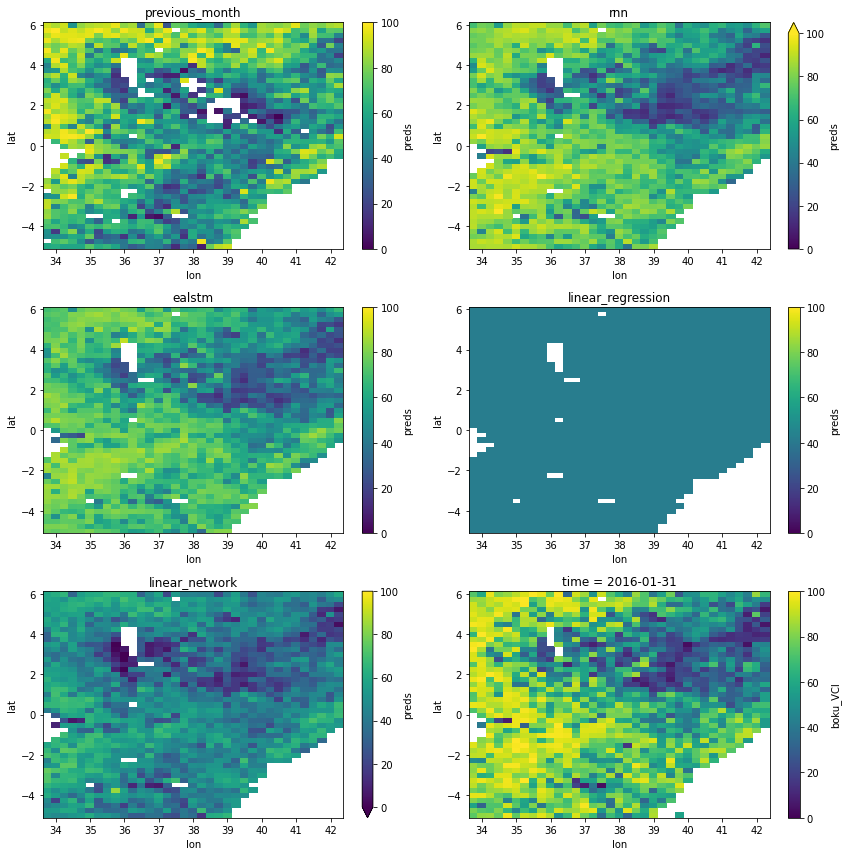

In [14]:
preds_dict = {"previous_month": bline_pred, 
"rnn": lstm_pred, 
"ealstm": ealstm_pred, 
"linear_regression": lr_pred, 
"linear_network": ln_pred}

fig, axs = plt.subplots(3, 2, figsize=(6*2, 4*3))

for ix, (model_name, preds) in enumerate(preds_dict.items()):
    ax = axs[np.unravel_index(ix, (3,2))]
    preds.isel(time=0).plot(ax=ax, vmin=0, vmax=100, cmap='viridis')
    ax.set_title(model_name)


ax = axs[np.unravel_index(5, (3,2))]
y_test[TARGET_VAR].isel(time=0).plot(ax=ax, vmin=0, vmax=100, cmap='viridis')
    
fig.tight_layout()

# Explore Temporal Errors

In [15]:
def calculate_error(true_da, pred_da, method=None):
    if method == 'squared':
        vals = (true_da.values - pred_da.values) ** 2
    elif method == 'absolute':
        vals = abs((true_da.values - pred_da.values))
    elif method == 'root':
        vals = np.sqrt((true_da.values - pred_da.values) ** 2)
    else:
        vals = (true_da.values - pred_da.values)
    da = xr.ones_like(true_da) * vals
    return da.rename(f'{method + "_" if method is not None else ""}error')


ealstm_error = calculate_error(
    pred_da=ealstm_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='root'
)
lstm_error = calculate_error(
    pred_da=lstm_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='root'
)
bline_error = calculate_error(
    pred_da=bline_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='root'
)
lr_error = calculate_error(
    pred_da=lr_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='root'
)
ln_error = calculate_error(
    pred_da=ln_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='root'
)

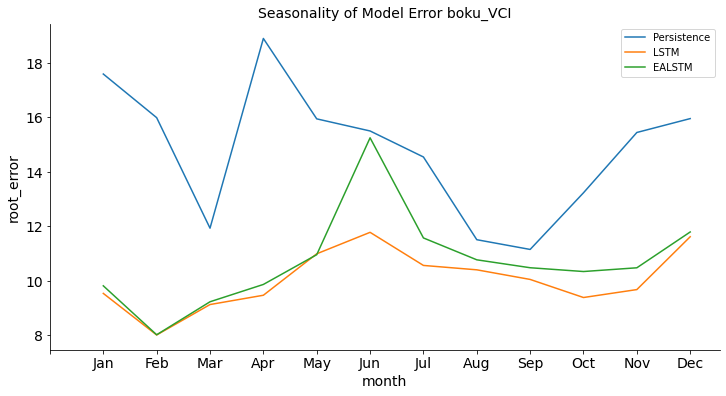

In [16]:
import calendar 
mths = [m for m in calendar.month_abbr]
fig, ax = plt.subplots(figsize=(12, 6))

bline_error.groupby('time.month').mean(dim=['time']).mean(dim=['lat', 'lon']).plot(ax=ax, label='Persistence')
lstm_error.groupby('time.month').mean(dim=['time']).mean(dim=['lat', 'lon']).plot(ax=ax, label='LSTM')
ealstm_error.groupby('time.month').mean(dim=['time']).mean(dim=['lat', 'lon']).plot(ax=ax, label='EALSTM')
plt.legend()

ax.set_title(f'Seasonality of Model Error {TARGET_VAR}', size=16);
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)
ax.set_ylabel(bline_error.name, size=14)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Explore Spatial Errors

In [17]:
from src.analysis import spatial_rmse, spatial_r2

# -------- LSTM
lstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    lstm_pred.transpose("time", "lat", "lon")
)

# -------- EALSTM
ealstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)

# -------- Baseline
bline_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)

# -------- Linear Network
ln_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
ln_pred.transpose("time", "lat", "lon")
)

# -------- Linear Regression
lr_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
lr_pred.transpose("time", "lat", "lon")
)

In [18]:
# -------- LSTM
lstm_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    lstm_pred.transpose("time", "lat", "lon")
)

# -------- EALSTM
ealstm_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)

# -------- Baseline
bline_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)

# -------- Linear Network
ln_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
ln_pred.transpose("time", "lat", "lon")
)

# -------- Linear Regression
lr_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
lr_pred.transpose("time", "lat", "lon")
)

In [19]:
rmses = {
    "lstm": lstm_rmse,
    "ealstm": ealstm_rmse,
    "persistence": bline_rmse,
    "lr": lr_rmse,
    "ln": ln_rmse,
}

r2s = {
    "lstm": lstm_r2,
    "ealstm": ealstm_r2,
    "persistence": bline_r2,
    "lr": lr_r2,
    "ln": ln_r2,
}

# Explore Performance for different Drought Classes

```
VCI3M Limits   | Description                        | Value
-----------------------------------------------------------
0 <= x <10     | Extreme vegetation deficit         |  1
10 <= x <20    | Severe vegetation deficit          |  2
20 <= x <35    | Moderate vegetation deficit        |  3
35 <= x <50    | Normal vegetation conditions       |  4
50 <= x <=100  | Above normal vegetation conditions |  5
```

### Calculate VDI

In [20]:
y_pred = ealstm_pred.compute()
y_true = ds[TARGET_VAR].sel(time=y_pred.time)

In [21]:
from src.analysis import VegetationDeficitIndex

v = VegetationDeficitIndex(
    data_dir / 'interim/VCI_preprocessed/data_kenya.nc',
    rolling_window=1
)
vdi_obs = v.vegetation_index_classify(y_true, 'vdi')
vdi_pred = v.vegetation_index_classify(y_pred, 'vdi')
vdi_train = v.vegetation_index_classify(y_train[TARGET_VAR], 'vdi')

This index is fit on a 3 month VCI moving average. Are you sure you want to fit for 1?


In [22]:
print("Overall Metrics")
print("---------------")
print(
    "Correct Classification:".ljust(30), f"{(vdi_obs == vdi_pred).mean().values:.2f}"
)
print(
    "Out by 1:".ljust(30), f"{(abs(vdi_obs - vdi_pred) == 1).mean().values:.2f}"
)
print(
    "Out by 2:".ljust(30), f"{(abs(vdi_obs - vdi_pred) == 2).mean().values:.2f}"
)
print(
    "Out by 3:".ljust(30), f"{(abs(vdi_obs - vdi_pred) == 3).mean().values:.2f}"
)
print("NOTE: bad metric because we have unbalanced class sizes")

Overall Metrics
---------------
Correct Classification:        0.59
Out by 1:                      0.34
Out by 2:                      0.06
Out by 3:                      0.01
NOTE: bad metric because we have unbalanced class sizes


### How many obs in each?

In [23]:
def plot_cdf(data: np.array, ax: Optional[plt.Axes] = None, **kwargs):
    """plot the sorted_data array against the number 
    of items smaller than each element in the array

    # https://stackoverflow.com/a/24576863/9940782
    """
    sorted_data = np.sort(data)
    sorted_data = sorted_data[~np.isnan(sorted_data)]
    
    # compute the proportion of values (y axis)
    yvals = np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(sorted_data, yvals, **kwargs)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    
    return ax

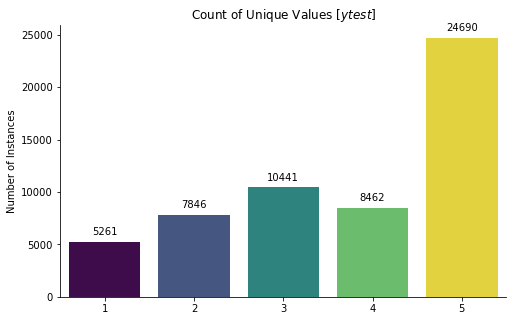

In [24]:
from matplotlib import cm


def get_unique_value_counts_xarray(da: xr.Dataset, dropna: bool = True) -> Dict[int, int]:
    """ NOTE only works for int-like data! (e.g. whole floats)"""
    if dropna:
        data = da.values.flatten()
        data = data[~np.isnan(data)]
    else:
        data = da.values.flatten()
    counts = np.bincount(data.astype(int))
    ii = np.nonzero(counts)[0]
    
    return dict(zip(ii, counts[ii]))


def plot_unique_value_counts(da: xr.DataArray, ax: Optional = None, label: bool = True) -> plt.Axes:
    """"""
    # create count of unique values
    counts = get_unique_value_counts_xarray(da)
    d = pd.DataFrame(
        counts, index=[0]
    )

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    n_unique_vals = len(counts)
    viridis = cm.get_cmap('viridis', n_unique_vals)(np.linspace(0, 1, n_unique_vals))
    g = sns.barplot(data=d, palette=viridis, ax=ax)
    ax.set_ylabel('Number of Instances')
    ax.set_title('Count of Unique Values')
    
    if label:
        for p in g.patches:
            g.annotate(
                format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points'
            )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax


ax = plot_unique_value_counts(vdi_obs)
ax.set_title('Count of Unique Values [$y test$]');

# ax = plot_unique_value_counts(vdi_pred.clip(1, 5))
# ax.set_title('Count of Unique Values [$y pred$]');

# ax = plot_unique_value_counts(vdi_train.clip(1, 5))
# ax.set_title('Count of Unique Values [$y train$]');

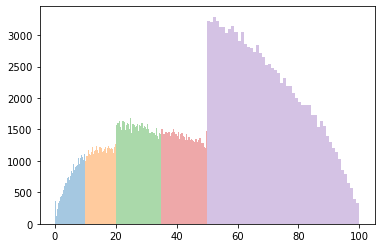

In [25]:
booleans = [
    (ds[TARGET_VAR] <= 10),
    (ds[TARGET_VAR] > 10) & (ds[TARGET_VAR] <= 20),
    (ds[TARGET_VAR] > 20) & (ds[TARGET_VAR] <= 35),
    (ds[TARGET_VAR] > 35) & (ds[TARGET_VAR] <= 50),
    (ds[TARGET_VAR] > 50),
]

fig, ax = plt.subplots()
viridis = cm.get_cmap('viridis', 5)(np.linspace(0, 1, 5))

for i in range(5):
    data = ds[TARGET_VAR].where(booleans[i]).values
    data = data[~np.isnan(data)]
    sns.distplot(data, kde=False, )

In [26]:
# fig, ax = plt.subplots(figsize=(12, 8))
# data = ds[TARGET_VAR].values
# data = data[~np.isnan(data)]
# sns.distplot(data, kde=False)

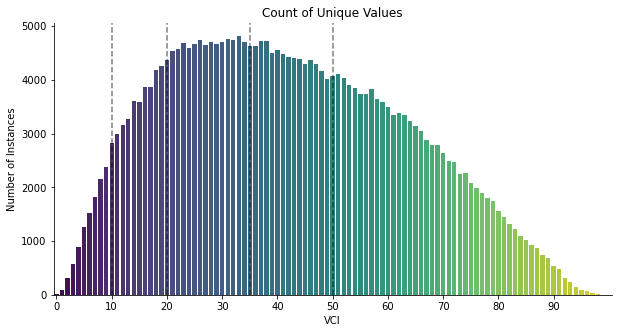

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = plot_unique_value_counts(np.round(ds['VCI3M']), label=False, ax=ax)

ax.set_xlabel('VCI')
ax.axvline(10, ls='--', c='k', alpha=0.5)
ax.axvline(20, ls='--', c='k', alpha=0.5)
ax.axvline(35, ls='--', c='k', alpha=0.5)
ax.axvline(50, ls='--', c='k', alpha=0.5)

ax.set_xticks(np.arange(0, 100, 10))
ax.set_xticklabels(np.arange(0, 100, 10));

In [28]:
# fig, ax = plt.subplots(figsize=(10, 5))

# data = ds[TARGET_VAR]
# ax = plot_unique_value_counts(np.round(data.where((data > 0) & (data < 100))), label=False, ax=ax)

# ax.set_xlabel('VCI')
# ax.axvline(10, ls='--', c='k', alpha=0.5)
# ax.axvline(20, ls='--', c='k', alpha=0.5)
# ax.axvline(35, ls='--', c='k', alpha=0.5)
# ax.axvline(50, ls='--', c='k', alpha=0.5)

# ax.set_xticks(np.arange(1, 99, 10))
# ax.set_xticklabels(np.arange(1, 99, 10));

In [29]:
# fig, ax = plt.subplots(figsize=(10, 5))

# ax = plot_unique_value_counts(np.round(ds['VCI']), label=False, ax=ax)

# ax.set_xlabel('VCI')
# ax.axvline(10, ls='--', c='k', alpha=0.5)
# ax.axvline(20, ls='--', c='k', alpha=0.5)
# ax.axvline(35, ls='--', c='k', alpha=0.5)
# ax.axvline(50, ls='--', c='k', alpha=0.5)

# ax.set_xticks(np.arange(0, 100, 10))
# ax.set_xticklabels(np.arange(0, 100, 10));

### Confusion Matrix

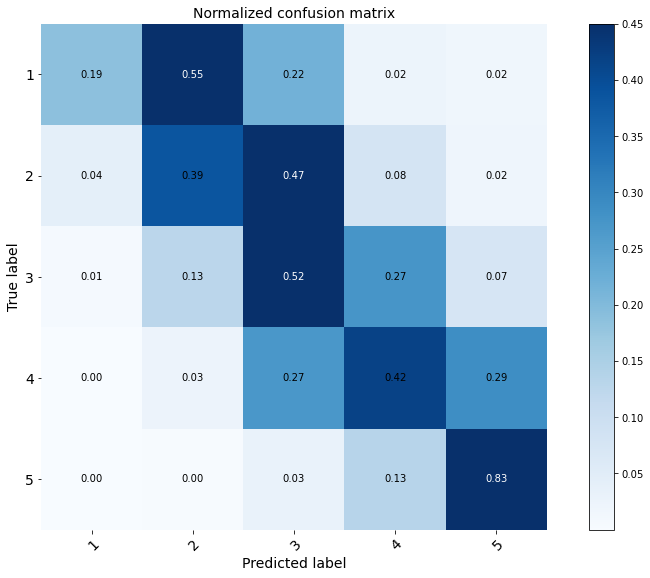

In [30]:
from scripts.drafts.plot_confusion import vdi_confusion_matrix

vmax = 0.75 if TARGET_VAR == "VCI3M" else 0.45

ax, conf_mat = vdi_confusion_matrix(
    vdi_obs,
    vdi_pred,
    normalize=True,
    **dict(vmax=vmax)
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
        
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

### Do correct predictions vary spatially?

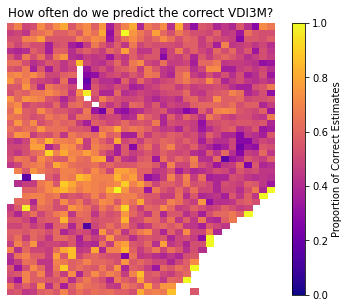

In [31]:
def plot_correct_predictions(pred, true, mask, ax=None) -> plt.Axes:
    """"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5))
    
    img = ax.pcolor(
        (pred == true).mean(dim='time').where(~mask).values,
        cmap='plasma',
        vmin=0, vmax=1
    )
    cbar = plt.colorbar(img, ax=ax)
    cbar.ax.set_ylabel("Proportion of Correct Estimates");
    
    ax.axis('off');
    
    return ax

ax = plot_correct_predictions(vdi_pred, vdi_obs, mask)
ax.set_title('How often do we predict the correct VDI3M?');

In [32]:
# plt_rows = 5
# plt_cols = 2
# fig, axs = plt.subplots(plt_rows, plt_cols, figsize=(6*plt_cols, 5*plt_rows))

# vdi_classes = np.unique(vdi_true.values)
# vdi_class = 1
# for row_ix, vdi_class in enumerate(vdi_classes):
#     ax1 = axs[row_ix, 0]
#     ax2 = axs[row_ix, 1]
#     # do we reproduce the observed spatial pattern
#     (vdi_true == vdi_class).mean(dim='time').where(~mask).plot(ax=ax1, vmin=0, vmax=1)
#     ax1.set_title(f'True VDI = {vdi_class}')
#     (vdi_pred == vdi_class).mean(dim='time').where(~mask).plot(ax=ax2, vmin=0, vmax=1)
#     ax2.set_title(f'Predicted VDI = {vdi_class}')

#     for ax in [ax1, ax2]:
#         ax.axis('off')

### Do correct predictions vary over time?

In [33]:
vdi_obs.stack(pixel=["lat", "lon"])  #.values.flatten().clip(min=1, max=5)
vdi_pred.stack(pixel=["lat", "lon"])  #.values.flatten().clip(min=1, max=5)

<xarray.DataArray 'vdi' (time: 36, pixel: 1575)>
array([[5, 5, 5, ..., 4, 5, 5],
       [5, 5, 5, ..., 3, 5, 4],
       [5, 5, 5, ..., 3, 4, 3],
       ...,
       [3, 4, 4, ..., 3, 5, 4],
       [3, 3, 3, ..., 4, 5, 5],
       [3, 3, 3, ..., 5, 5, 5]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
  * pixel    (pixel) MultiIndex
  - lat      (pixel) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... 6.0 6.0 6.0 6.0 6.0
  - lon      (pixel) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25

### Seasonality

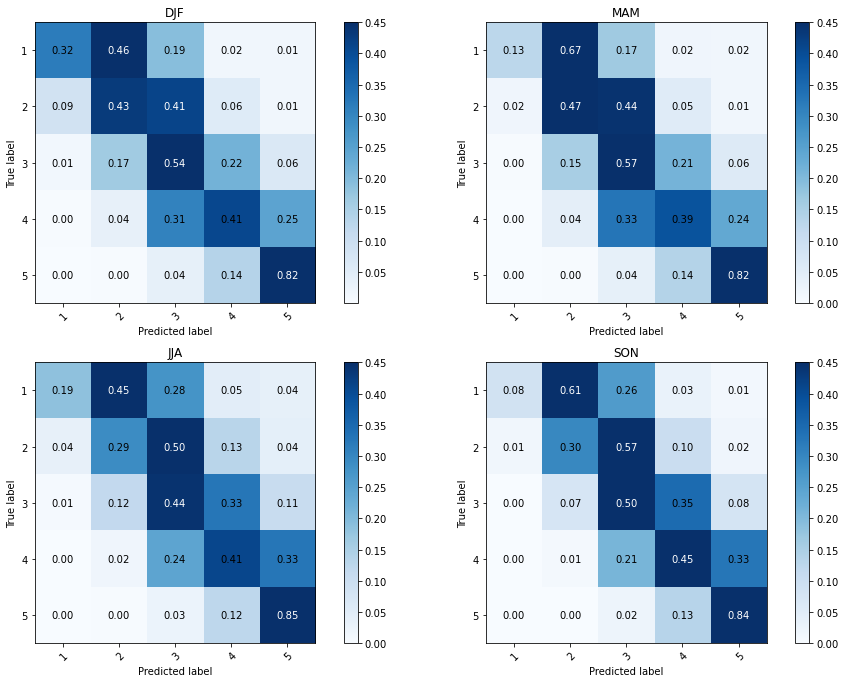

In [34]:
vmax = 0.75 if TARGET_VAR == "VCI3M" else 0.45


def create_season_ds(vdi):
    vdi['season'] = vdi['time.season']
    return vdi

seasons = ['DJF', 'MAM', 'JJA', 'SON']

scale = 0.6
fig, axs = plt.subplots(2,2, figsize=((12*scale) * 2, (8*scale) * 2))

for ix, season in enumerate(seasons):
    ax = axs[np.unravel_index(ix, (2, 2))]
    season_pred = create_season_ds(vdi_pred)
    season_pred = season_pred[season_pred['season'] == season]

    season_true = create_season_ds(vdi_obs)
    season_true = season_true[season_true['season'] == season]

    vdi_confusion_matrix(
        season_true,
        season_pred,
        normalize=True,
        **dict(vmax=vmax),
        title=season,
        ax=ax
    )

### What about performance per month?

In [35]:
import calendar

def create_month_ds(vdi):
    vdi['month'] = vdi['time.month']
    return vdi

# label dataarray with month and season
month_pred = create_month_ds(vdi_pred)
month_true = create_month_ds(vdi_obs)

# 
all_months = []
for month in range(1, 13):
    n_data_points = len(month_true[month_true.month == month].time)
    
    # how many times do we correctly predict the VDI?
    sum_of_correct = (
        (month_pred[month_pred.month == month] == month_true[month_true.month == month])
        .sum(dim='time')
    )
    sum_of_correct = sum_of_correct.assign_coords(time=month).expand_dims('time')
    
    # create proportion of correct predictions
    prop_of_correct = sum_of_correct / n_data_points
    all_months.append(prop_of_correct)
    
month_errors = xr.concat(all_months, dim='time').where(~mask)

# create dataframe of mean over space
month_df = month_errors.mean(dim=['lat', 'lon']).to_dataframe()
month_df = month_df.reset_index().rename(columns={'time': 'month_id', "vdi": "prop_correct"})
month_df['month'] = month_df.apply(lambda x: calendar.month_abbr[int(x.month_id)], axis=1)
month_df['season'] = ['DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF']
month_df.head()

,month_id,prop_correct,month,season
0,1,0.580359,Jan,DJF
1,2,0.554700,Feb,DJF
2,3,0.488687,Mar,MAM
3,4,0.546070,Apr,MAM
4,5,0.618148,May,MAM


Text(0.5, 0, 'Month')

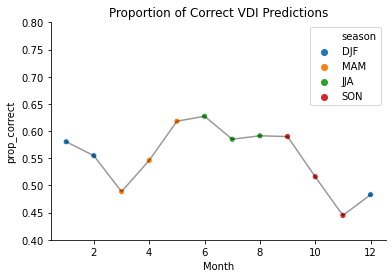

In [36]:
# sns.barplot(x='month', y='prop_correct', hue='season', data=month_df)
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(x='month_id', y='prop_correct', data=month_df, color='k', alpha=0.4)
sns.scatterplot(x='month_id', y='prop_correct', hue='season', data=month_df)

ylim = (0.6, 0.9) if TARGET_VAR == "VCI3M" else (0.4, 0.8)

# ax.get_legend().remove()
ax.set_ylim(ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Proportion of Correct VDI Predictions')
ax.set_xlabel('Month')


# ## Plot the Maps of each month performance
# fig, axs = plt.subplots(3, 4, figsize=(1.2*4, 1.5*3))

# for ix, month in enumerate(month_errors.time.values):
#     ax = axs[np.unravel_index(ix, (3, 4))]
#     month_errors.sel(time=month).plot(ax=ax, cmap='viridis_r', vmin=0, vmax=1, add_colorbar=False, )  # 
#     ax.set_title(calendar.month_abbr[month])
#     ax.axis('off')

# ax.set_xlim(0, 1)
# plt.tight_layout()

In [37]:
[d.name for d in (data_dir / "interim/boku_ndvi_1000_preprocessed").iterdir()]

['data_kenya.nc_',
 'arr.txt',
 'DEKAD_data_kenya.nc_',
 'MON_data_kenya.nc_',
 'install.sh',
 'data_kenya.nc',
 '.bashrc',
 'data_kenya.nc_badVCI3M']

In [38]:
mon = xr.open_dataset(data_dir / "interim/boku_ndvi_1000_preprocessed/data_kenya.nc")

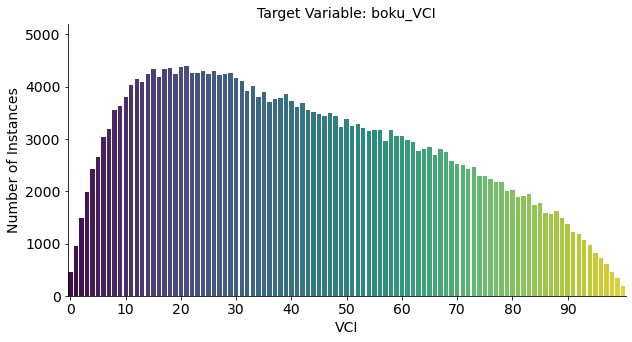

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = plot_unique_value_counts(np.round(ds[TARGET_VAR]), label=False, ax=ax)

ax.set_xlabel('VCI')
ax.set_ylim(0, 5200)

# ax.axvline(10, ls='--', c='k', alpha=0.9, lw=3)
# ax.axvline(20, ls='--', c='k', alpha=0.9, lw=3)
# ax.axvline(35, ls='--', c='k', alpha=0.9, lw=3)
# ax.axvline(50, ls='--', c='k', alpha=0.9, lw=3)

ax.set_xticks(np.arange(0, 100, 10))
ax.set_xticklabels(np.arange(0, 100, 10))

ax.set_title(f"Target Variable: {TARGET_VAR}")

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14);

### Get boundaries in Africa

In [40]:
import geopandas as gpd

gdf = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
africa = gdf.query("continent == 'Africa'")

### chop out Kenya

In [41]:
kenya = gdf.query("name == 'Kenya'")

In [42]:
from scripts.drafts.mask_using_shapefile import rasterize

In [43]:
shapes = [(shape, n) for n, shape in enumerate(kenya.geometry)]
xr_da = ds[TARGET_VAR]

In [44]:
kenya_xr = rasterize(
    shapes, xr_da.coords, longitude='lon', latitude='lat'
)
kenya_mask = np.isnan(kenya_xr)

# plot the target variables
- https://jdhao.github.io/2017/06/11/mpl_multiplot_one_colorbar/
- http://xarray.pydata.org/en/stable/generated/xarray.plot.FacetGrid.html#xarray.plot.FacetGrid


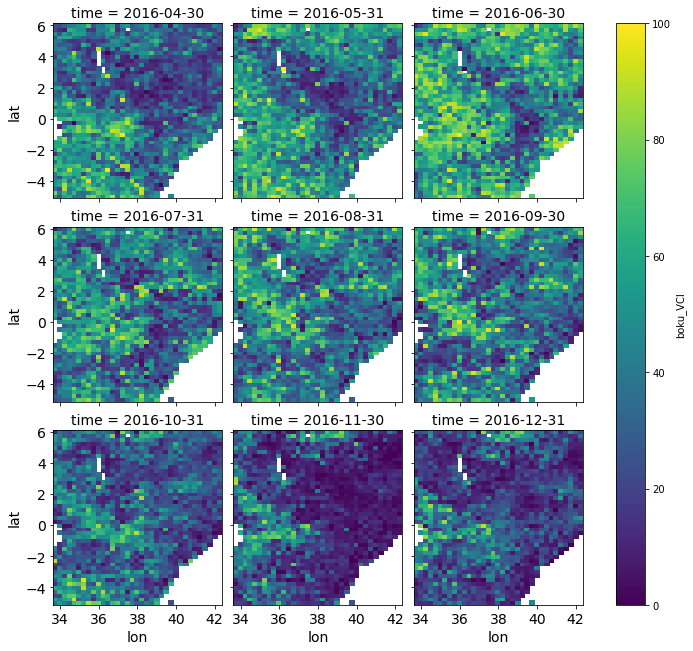

In [45]:
nrows = 1
ncols = 1
# fig, ax = plt.subplots(nrows, ncols, figsize=((8*ncols), (8*nrows)))

time = y_test.isel(time=0).time
g = y_test[TARGET_VAR].isel(time=slice(3, 12)).plot(col='time', col_wrap=3)

# kenya.plot(ax=ax, facecolor='none', edgecolor='k', lw=2, alpha=0.6, vmin=0, vmax=100)

for i, ax in enumerate(g.axes.flat):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                      + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(14);

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# fig = plt.gcf()

In [46]:
[m for m in dir(fig) if 'color' in m]

['colorbar',
 'get_edgecolor',
 'get_facecolor',
 'set_edgecolor',
 'set_facecolor']

# Data inputs

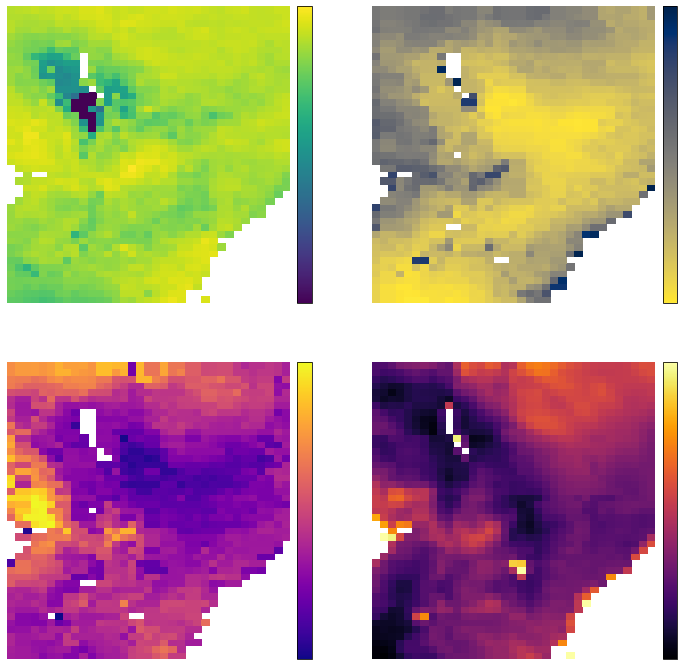

In [47]:
dynamic_vars = [v for v in dynamic_ds.data_vars][1:]
varnames = ["VCI", "Precipitation", "Evaporation", "2m Air Temperature"]
colormaps = ['viridis', 'cividis_r', 'plasma', 'inferno']

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2, 2, figsize=(6*2, 6*2))
for ix, (var, name, cmap) in enumerate(zip(dynamic_vars, varnames, colormaps)):
    ax = axs[np.unravel_index(ix, (2, 2))]
    data = dynamic_ds[var].isel(time=10).where(~mask).values
    
    
    im = ax.pcolor(data, cmap=cmap)
    
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical',)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_ticks([])
    
    ax.axis('off')
    
    # 
    # ax.set_title(name)
    ax.set_title('')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14);
    

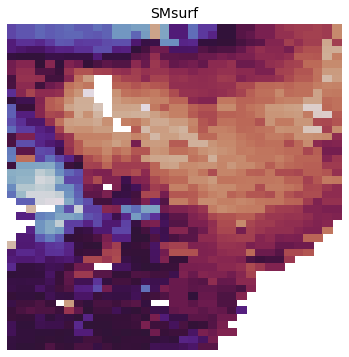

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
data = ds["SMsurf"].mean(dim='time').where(~mask).values

im = ax.pcolor(data, cmap='twilight_r')

# colorbar
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.1)
# cbar = fig.colorbar(im, cax=cax, orientation='vertical', label="SMsurf")

# 
ax.axis('off');
ax.set_title("SMsurf")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
              + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14);
    

In [50]:
static_vars = [v for v in static.data_vars if v not in ["lc_class", "lc_class_group"]]
static_vars = [v for v in static_vars if "global" not in v]
print(static_vars)

cmaps = ['cividis', 'plasma', 'inferno', 'inferno', 'gist_earth', 'viridis', 'viridis', 'viridis', 'viridis', 'viridis', 'viridis', 'viridis', 'viridis', 'viridis', 'viridis', 'viridis', 'tab10']

assert len(cmaps) == len(static_vars), print(f"{len(cmaps)}, {len(static_vars)}")
print(len(cmaps))

['precip_pixel_mean', 'E_pixel_mean', 'SMsurf_pixel_mean', 'pev_pixel_mean', 'topography', 'cropland_rainfed_one_hot', 'herbaceous_cover_one_hot', 'tree_or_shrub_cover_one_hot', 'cropland_irrigated_or_postflooding_one_hot', 'tree_cover_one_hot', 'shrubland_one_hot', 'grassland_one_hot', 'urban_areas_one_hot', 'bare_areas_one_hot', 'water_bodies_one_hot', 'permanent_snow_and_ice_one_hot', 'slt']
17


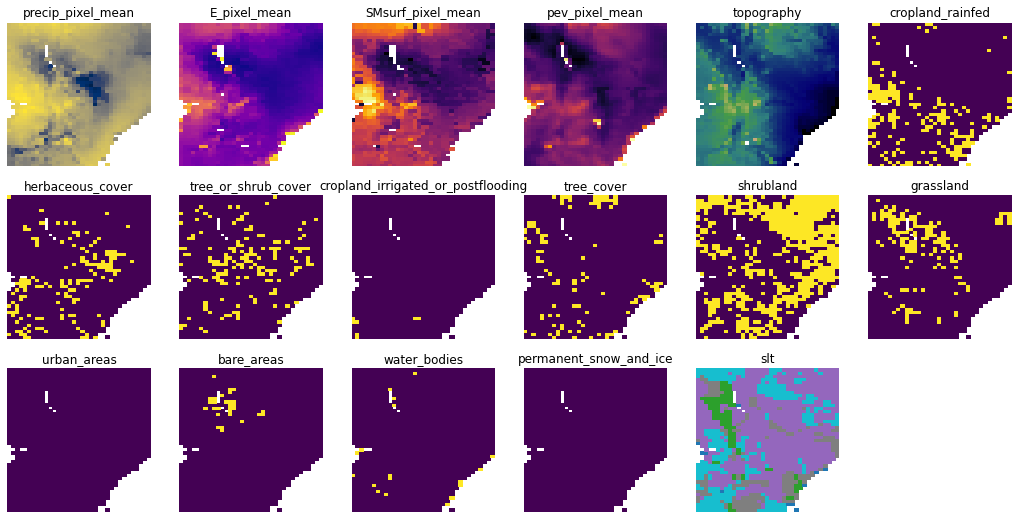

In [51]:
nrows = 3
ncols = 6
fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

ix = 0
for ix, (var, cmap) in enumerate(zip(static_vars, cmaps)):
    var = static_vars[ix]
    cmap = cmaps[ix]

    ax = axs[np.unravel_index(ix, (nrows, ncols))]

    data = static[var].where(~mask).values
    im = ax.pcolor(data, cmap=cmap)
    ax.set_title(var.replace("_one_hot", "") if "one_hot" in var else var)
    ax.axis('off');

for ax in axs.flatten():
    ax.axis('off')

In [52]:
static.topography.median()

<xarray.DataArray 'topography' ()>
array(785.5, dtype=float32)